# TP : Parcelle.

Goal : Find the best rectangle in a parcelle, the rectangle must be inside the parcelle and the area of the rectangle must be maximized.

We will use ABC algorithm to solve this problem.



## Import librairies

In [300]:
from matplotlib.pyplot import semilogy
from functools import partial, reduce
import numpy as np
import sys
import matplotlib.pyplot as plt
import pyclipper
import shapely
import shapely.geometry as sg
import shapely.ops as so
from typing import List, Tuple, Dict
import random
from tqdm import tqdm

## Learn Shapely Lib

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_1672\1550311331.py:5: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  new_shape_1 = so.cascaded_union([r1, r2, r3])


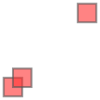

In [301]:
r1 = sg.Polygon([(0, 0), (0, 1), (1, 1), (1, 0), (0, 0)])
r2 = sg.box(0.5, 0.5, 1.5, 1.5)
r3 = sg.box(4, 4, 5, 5)

new_shape_1 = so.cascaded_union([r1, r2, r3])
new_shape_2 = sg.MultiPolygon([r1, r2, r3])

new_shape_2

In [413]:
def repare_polygons(polygons: List[List[tuple]]) -> List[sg.Polygon]:
    polygons = [sg.Polygon(poly) for poly in polygons]  # convert to shapely polygon
    polygons = [poly.buffer(0) for poly in polygons]  # remove duplicate points
    polygons = [poly for poly in polygons if not poly.is_empty]  # remove empty polygons
    return polygons


def generate_polygons(num_polygons, num_vertices, max_x, max_y):
    polygons = []
    for i in range(num_polygons):
        vertices = []
        for j in range(num_vertices):
            x = random.randint(0, max_x)
            y = random.randint(0, max_y)
            vertices.append((x, y))
        polygons.append(vertices)
    return repare_polygons(polygons)


polygones = generate_polygons(10, 6, 500, 500)
polygones

[<POLYGON ((163 408, 167.794 394.585, 442 440, 400 218, 209.051 279.124, 302 ...>,
 <MULTIPOLYGON (((372.019 95.369, 188 109, 79 347, 178 203, 372.019 95.369)),...>,
 <POLYGON ((390.073 205.605, 368 458, 462.763 152.211, 493 130, 463.899 148.5...>,
 <POLYGON ((264.867 263.945, 376 414, 341.312 301.194, 204 28, 264.867 263.945))>,
 <MULTIPOLYGON (((229.165 116.811, 172 22, 61 71, 229.165 116.811)), ((288.42...>,
 <POLYGON ((328.973 415.557, 440 393, 413.37 175.821, 1 95, 328.973 415.557))>,
 <MULTIPOLYGON (((154.743 366.08, 122 450, 434 328, 339.208 340.926, 302 374,...>,
 <POLYGON ((118.563 290.377, 175.038 268.706, 183 56, 73 89, 118.563 290.377))>,
 <POLYGON ((248 497, 376 462, 272 458, 219 396, 241 119, 211 399, 248 497))>,
 <POLYGON ((11 306, 86 428, 304.102 244.635, 192 199, 11 306))>]

### Plot

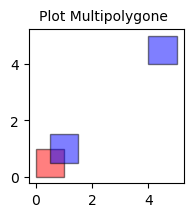

TypeError: 'MultiPolygon' object is not subscriptable

In [414]:
def plot_multipolygone(polygones: List[sg.Polygon | sg.MultiPolygon], coef_figsize=1, title=None):
    # create multipolygon from list of polygons
    mp = sg.MultiPolygon(polygones) if isinstance(polygones[0], sg.Polygon) else polygones

    fig, axs = plt.subplots(figsize=(coef_figsize * 4, coef_figsize * 4))
    fig.suptitle(title, fontsize=10) if title is not None else None
    axs.set_aspect('equal', 'datalim')

    #color_list = ['r', "b", 'g', "y", "c", "m", "k", "w"]
    color_list = ["r"] + ["b"] * (len(polygones) - 1)
    i = 0
    for geom in mp.geoms:
        xs, ys = geom.exterior.xy
        axs.fill(xs, ys, alpha=0.5, fc=color_list[i % len(color_list)], ec='black')
        i += 1

    plt.show()


plot_multipolygone([r1, r2, r3], title="Plot Multipolygone", coef_figsize=0.5)

## Parcelles

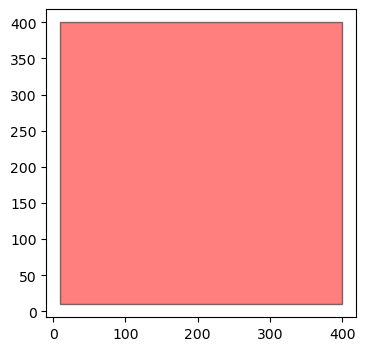

In [493]:
# polygone toujours des coordonéne positives
PARCELLE_COORDS = [(10, 10), (10, 400), (400, 400), (400, 10)]
# random polygone
#PARCELLE_COORDS = [(10, 10), (10, 400), (400, 400), (400, 10), (300, 300), (300, 200)]

plot_multipolygone([sg.Polygon(PARCELLE_COORDS)])

## Params

In [304]:
DIM = 5

INF_DICT = {}
SUP_DICT = {}

# bounds
KEYS_FEATURES_RECT = ["x", "y", "long", "larg", "rot"]

INF_DICT["x"] = 0
INF_DICT["y"] = 0
INF_DICT["long"] = 0
INF_DICT["larg"] = 0
INF_DICT["rot"] = -180

SUP_DICT["x"] = max([x for x, y in PARCELLE_COORDS])
SUP_DICT["y"] = max([y for x, y in PARCELLE_COORDS])
SUP_DICT["long"] = max([x for x, y in PARCELLE_COORDS])
SUP_DICT["larg"] = max([y for x, y in PARCELLE_COORDS])
SUP_DICT["rot"] = 180

## Solution (Rectangle)

In [305]:
def init_solution(infs: dict = INF_DICT, sups: dict = SUP_DICT) -> dict:
    rect = {}
    for key in KEYS_FEATURES_RECT:
        rect[key] = np.random.randint(infs[key], sups[key])
    return rect


init_solution()

{'x': 180, 'y': 237, 'long': 226, 'larg': 55, 'rot': 73}

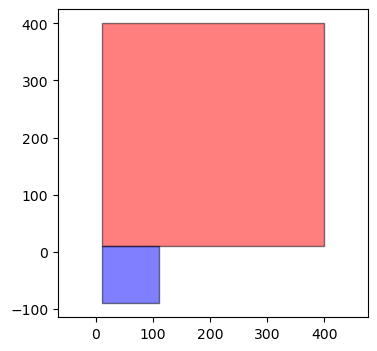

In [306]:
def plot_rect_solutions(solutions: List[dict], parcelle_coords: List[tuple], coef_figsize=1, title=None):
    polygons = [sg.Polygon(parcelle_coords)] + [sg.Polygon(solution_to_coords_list(sol)) for sol in solutions]
    plot_multipolygone(polygons, coef_figsize=coef_figsize, title=title)


test_rect = {"x": 10, "y": 10, "long": 100, "larg": 100, "rot": 270}
plot_rect_solutions(solutions=[test_rect], parcelle_coords=PARCELLE_COORDS)

[(10, 10), (-7.3648177666930295, -88.4807753012208), (91.11595753452778, -105.84559306791382), (108.4807753012208, -7.3648177666930295)]
{'x': 10, 'y': 10, 'long': 100.0, 'larg': 100.0, 'rot': -100.0}


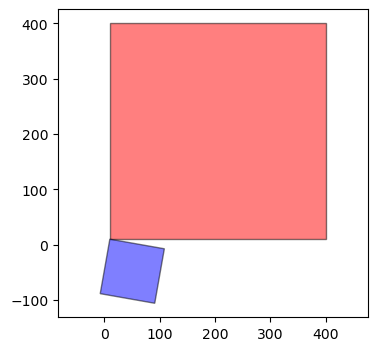

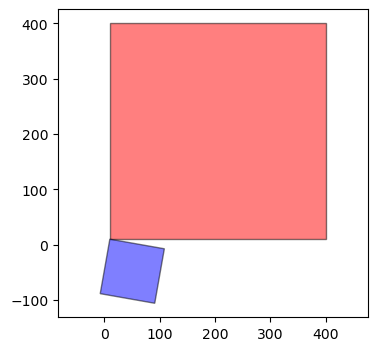

In [307]:
def solution_to_coords_list(sol: dict) -> List[tuple]:
    """
    Convert a solution to a list of coordinates
    """
    cos_rot = np.cos(np.deg2rad(sol["rot"]))
    sin_rot = np.sin(np.deg2rad(sol["rot"]))
    p1 = (sol["x"], sol["y"])
    p2 = (p1[0] + sol["long"] * cos_rot, p1[1] + sol["long"] * sin_rot)
    p3 = (p1[0] - sol["larg"] * sin_rot, p1[1] + sol["larg"] * cos_rot)
    p4 = (p2[0] - sol["larg"] * sin_rot, p2[1] + sol["larg"] * cos_rot)
    return [p1, p2, p4, p3]


def coords_list_to_solution(coords_list: List[tuple]) -> dict:
    """
    Convert a list of coordinates to a solution
    """
    p1, p2, p4, p3 = coords_list
    sol = {}
    sol["x"] = p1[0]
    sol["y"] = p1[1]
    sol["long"] = np.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)
    sol["larg"] = np.sqrt((p3[0] - p1[0]) ** 2 + (p3[1] - p1[1]) ** 2)
    sol["rot"] = np.rad2deg(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))
    return sol


test_rect = {"x": 10, "y": 10, "long": 100, "larg": 100, "rot": -100}

print(solution_to_coords_list(test_rect))
print(coords_list_to_solution(solution_to_coords_list(test_rect)))
plot_rect_solutions(solutions=[test_rect], parcelle_coords=PARCELLE_COORDS)
plot_rect_solutions(solutions=[coords_list_to_solution(solution_to_coords_list(test_rect))],
                    parcelle_coords=PARCELLE_COORDS)

## Population

In [308]:
def init_population(n: int = 5, infs: dict = INF_DICT, sups: dict = SUP_DICT) -> List[dict]:
    return [init_solution(infs=infs, sups=sups) for _ in range(n)]


test_pop = init_population(10)
test_pop

[{'x': 354, 'y': 87, 'long': 314, 'larg': 123, 'rot': -180},
 {'x': 131, 'y': 243, 'long': 140, 'larg': 127, 'rot': -71},
 {'x': 241, 'y': 192, 'long': 172, 'larg': 64, 'rot': -9},
 {'x': 244, 'y': 125, 'long': 180, 'larg': 88, 'rot': 30},
 {'x': 231, 'y': 199, 'long': 266, 'larg': 270, 'rot': 57},
 {'x': 143, 'y': 350, 'long': 15, 'larg': 150, 'rot': -153},
 {'x': 22, 'y': 306, 'long': 240, 'larg': 137, 'rot': 21},
 {'x': 293, 'y': 389, 'long': 135, 'larg': 195, 'rot': -83},
 {'x': 128, 'y': 101, 'long': 157, 'larg': 7, 'rot': 133},
 {'x': 287, 'y': 96, 'long': 371, 'larg': 293, 'rot': 175}]

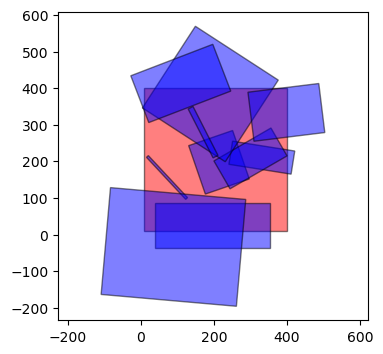

In [309]:
plot_rect_solutions(solutions=test_pop, parcelle_coords=PARCELLE_COORDS, coef_figsize=1)


## Faisability

Validity of a rectangle in a parcel

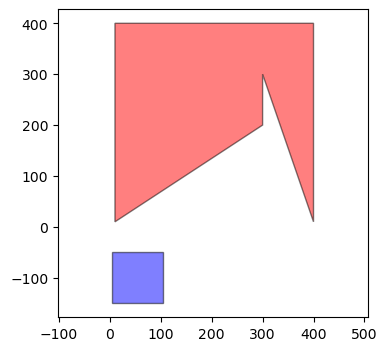

False
False
0.0
120050.0


In [439]:
test_rect = {"x": 5, "y": -50, "long": 100, "larg": 100, "rot": 270}


def parcelle_contains_rect(rect: List[tuple], parcelle_coords: List[tuple]) -> bool:
    return sg.Polygon(parcelle_coords).contains(sg.Polygon(rect))


def parcelle_intersects_rect(rect: List[tuple], parcelle_coords: List[tuple]) -> bool:
    return sg.Polygon(parcelle_coords).intersects(sg.Polygon(rect))


def parcelle_intersection_area(rect: List[tuple], parcelle_coords: List[tuple]) -> float:
    return sg.Polygon(parcelle_coords).intersection(sg.Polygon(rect)).area


def parcelle_union_area(rect: List[tuple], parcelle_coords: List[tuple]) -> float:
    return sg.Polygon(parcelle_coords).union(sg.Polygon(rect)).area


def area(rect: List[tuple]) -> float:
    return sg.Polygon(rect).area


plot_rect_solutions(solutions=[test_rect], parcelle_coords=PARCELLE_COORDS, coef_figsize=1)
print(parcelle_contains_rect(solution_to_coords_list(test_rect), PARCELLE_COORDS))
print(parcelle_intersects_rect(solution_to_coords_list(test_rect), PARCELLE_COORDS))
print(parcelle_intersection_area(solution_to_coords_list(test_rect), PARCELLE_COORDS))
print(parcelle_union_area(solution_to_coords_list(test_rect), PARCELLE_COORDS))

## Fitness

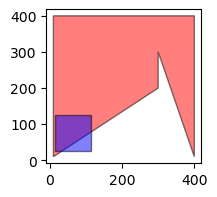

583.3030852994561

In [488]:
def fitness(sol: dict, parcelle_coords: List[tuple]) -> float:
    rect = solution_to_coords_list(sol)
    if parcelle_contains_rect(rect, parcelle_coords):
        return area(rect)
    else:
        intersection_area = parcelle_intersection_area(rect, parcelle_coords)
        rect_area = area(rect)
        if intersection_area == 0 or rect_area == 0:
            return 0


        diff_area = rect_area - intersection_area

        ratio_intersection_rect = intersection_area / rect_area
        ratio_diff_rect = diff_area / rect_area
        #print(intersection_area, diff_area)
        #print(ratio_intersection_rect, ratio_diff_rect)
        if ratio_intersection_rect < 0.25:
            return 0

        euh_rate = 0.5
        fit = intersection_area * euh_rate - diff_area * (1 +  (1 - euh_rate))
        return fit if fit > 0 else 0


test_rect = {"x": 15, "y": 125, "long": 100, "larg": 100, "rot": 270}
plot_rect_solutions(solutions=[test_rect], parcelle_coords=PARCELLE_COORDS, coef_figsize=0.5)
fitness(test_rect, PARCELLE_COORDS)

## Best Solution

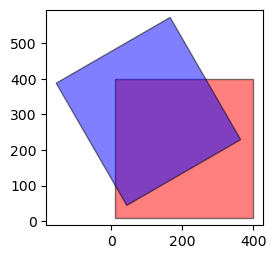

In [313]:
def is_better(sol1: dict, sol2: dict, parcelle_coords: List[tuple]) -> bool:
    return fitness(sol1, parcelle_coords) > fitness(sol2, parcelle_coords)


def max_solution(sol1: dict, sol2: dict, parcelle_coords: List[tuple]) -> dict:
    if is_better(sol1, sol2, parcelle_coords):
        return sol1
    else:
        return sol2


def get_best_solution(population: List[dict], parcelle_coords: List[tuple]) -> dict:
    return reduce(lambda sol1, sol2: max_solution(sol1, sol2, parcelle_coords), population)


best_sol = get_best_solution(init_population(200), PARCELLE_COORDS)
plot_rect_solutions(solutions=[best_sol], parcelle_coords=PARCELLE_COORDS, coef_figsize=0.7)

## Operators

In [314]:
# Sélection de n individus différents de x
def select_random_solutions(population: List[dict], x: dict, n: int = 1) -> List[dict]:
    if n > len(population) - 1:
        raise ValueError("n must be lower than the population size")
    population_without_x = [sol for sol in population if sol != x]
    return random.choices(population_without_x, k=n)


select_random_solutions(init_population(10), test_pop[0], 3)

[{'x': 212, 'y': 128, 'long': 395, 'larg': 143, 'rot': 103},
 {'x': 59, 'y': 110, 'long': 84, 'larg': 22, 'rot': 67},
 {'x': 382, 'y': 23, 'long': 17, 'larg': 34, 'rot': 36}]

In [454]:
def get_probabilities(fitnesses):
    sum_fitnesses = np.sum(fitnesses)
    if sum_fitnesses == 0:
        return np.ones(len(fitnesses)) / len(fitnesses)
    else:
        return np.array(fitnesses) / sum_fitnesses


def selection_roulette_wheel(population: List[dict], probas: List[float]) -> np.ndarray:
    idx = np.random.choice(len(population), p=probas)
    #print(idx,probabilities[idx])
    return population[idx], idx

### Neighbor

Initial solution :  {'x': 287, 'y': 96, 'long': 371, 'larg': 293, 'rot': 175}
Other solution :  {'x': 287, 'y': 96, 'long': 371, 'larg': 293, 'rot': 175}
Neighbor :  {'x': 287, 'y': 96, 'long': 371, 'larg': 293.0, 'rot': 175}


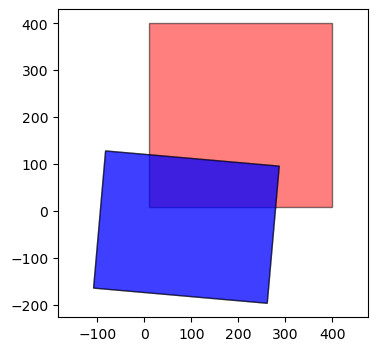

Repare :  {'x': 287, 'y': 96, 'long': 371, 'larg': 293.0, 'rot': 175}


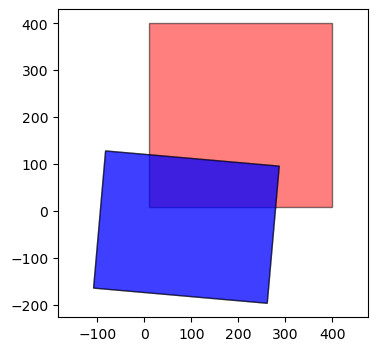

In [316]:
def generate_neighbor(sol: dict, other_sol: dict):
    """
    Generate a neighbor of sol by changing a random feature
    """
    sol_neighbor = sol.copy()
    key = random.choice(KEYS_FEATURES_RECT)
    phi = np.random.uniform(-1, 1)
    sol_neighbor[key] = sol[key] + phi * (other_sol[key] - sol[key])
    return sol_neighbor


# generate a neighbor with other source and best source
def generate_neighbor_with_best(sol: dict, other_sol: dict, best_sol: dict, C: float = 1.5):
    """
    Generate a neighbor of sol by changing a random feature
    """
    sol_neighbor = sol.copy()
    key = random.choice(KEYS_FEATURES_RECT)
    phi = np.random.uniform(-1, 1)
    psi = np.random.uniform(0, C)
    sol_neighbor[key] = sol[key] + phi * (other_sol[key] - sol[key]) + psi * (best_sol[key] - sol[key])
    return sol_neighbor


def repare_solution(sol: dict, infs: dict, sups: dict):
    """
    Repare a solution if it is not valid
    """
    sol_repare = sol.copy()

    sol_repare["rot"] = sol_repare["rot"] % 360
    keys_without_rot = KEYS_FEATURES_RECT.copy()
    keys_without_rot.remove("rot")
    for key in keys_without_rot:
        if sol_repare[key] < infs[key]:
            sol_repare[key] = infs[key]
        elif sol_repare[key] > sups[key]:
            sol_repare[key] = sups[key]
    return sol_repare


sol, other_sol = select_random_solutions(test_pop, test_pop[0], 2)
print("Initial solution : ", sol)
print("Other solution : ", other_sol)
new_sol = generate_neighbor(sol, other_sol)
print("Neighbor : ", new_sol)
plot_rect_solutions(solutions=[sol, new_sol], parcelle_coords=PARCELLE_COORDS, coef_figsize=1)
print("Repare : ", repare_solution(new_sol, INF_DICT, SUP_DICT))
plot_rect_solutions(solutions=[sol, repare_solution(new_sol, INF_DICT, SUP_DICT)], parcelle_coords=PARCELLE_COORDS,
                    coef_figsize=1)

### Employed bee phase

In [317]:
def foraging_source(sol: dict, population: List[dict], parcelle_coords: List[tuple], C=1.5, type_neighbor="rand",
                    infs: dict = INF_DICT, sups: dict = SUP_DICT) -> Tuple[dict, bool]:
    """
    Foraging source phase
    """
    # select a random solution different from sol
    other_sol = select_random_solutions(population, sol, 1)[0]

    if type_neighbor == "rand":
        new_sol = generate_neighbor(sol, other_sol)
    elif type_neighbor == "rand/best":
        best_sol = get_best_solution(population, parcelle_coords)
        new_sol = generate_neighbor_with_best(sol, other_sol, best_sol, C=C)
    else:
        raise ValueError("type_neighbor must be 'rand' or 'rand/best'")

    new_sol = repare_solution(new_sol, infs, sups)
    if is_better(new_sol, sol, parcelle_coords):
        return new_sol, True
    else:
        return new_sol, False


print("Initial solution : ", test_pop[0])
print("New solution : ", foraging_source(test_pop[0], test_pop, PARCELLE_COORDS, type_neighbor="rand/best"))

Initial solution :  {'x': 354, 'y': 87, 'long': 314, 'larg': 123, 'rot': -180}
New solution :  ({'x': 354, 'y': 87, 'long': 314, 'larg': 123, 'rot': 55.262312913319306}, False)


In [318]:
def employed_bees_phase(current_population: List[dict], parcelle_coords: List[tuple], trial_counter: np.ndarray, C=1.5,
                        type_neighbor="rand", infs: dict = INF_DICT, sups: dict = SUP_DICT
                        ) -> List[dict]:
    """
    Employed bees phase
    """
    for idx, sol in enumerate(current_population):
        new_sol, is_better_sol = foraging_source(sol, current_population, parcelle_coords, C, type_neighbor, infs, sups)
        if is_better_sol:
            current_population[idx] = new_sol
            trial_counter[idx] = 0
        else:
            trial_counter[idx] += 1

    return current_population, trial_counter


employed_bees_phase(test_pop, PARCELLE_COORDS, type_neighbor="rand/best", trial_counter=np.zeros(len(test_pop)))

([{'x': 354, 'y': 87, 'long': 314, 'larg': 123, 'rot': -180},
  {'x': 131, 'y': 243, 'long': 140, 'larg': 127, 'rot': 349.51597221806077},
  {'x': 241, 'y': 192, 'long': 172, 'larg': 64, 'rot': -9},
  {'x': 244, 'y': 125, 'long': 180, 'larg': 338.26740483475794, 'rot': 30},
  {'x': 231, 'y': 199, 'long': 266, 'larg': 270, 'rot': 57},
  {'x': 143, 'y': 350, 'long': 15, 'larg': 150, 'rot': -153},
  {'x': 22, 'y': 306, 'long': 240, 'larg': 137, 'rot': 21},
  {'x': 293, 'y': 389, 'long': 359.55441547820334, 'larg': 195, 'rot': 277},
  {'x': 128, 'y': 101, 'long': 367.04635066160495, 'larg': 7, 'rot': 133},
  {'x': 287, 'y': 96, 'long': 371, 'larg': 293, 'rot': 220.2759026570653}],
 array([1., 0., 1., 0., 1., 1., 1., 0., 0., 0.]))

### Onlooker bee phase

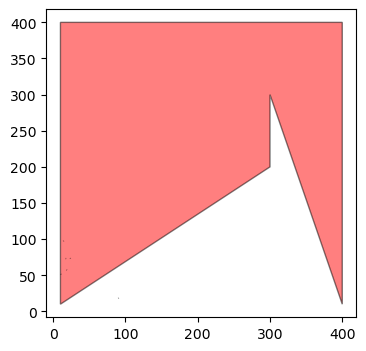

Trial counter :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Trial counter :  [2. 3. 3. 3. 2. 1. 2. 2. 0. 2.]


In [455]:
def onlooker_bees_phase(n_bees: int, current_population: List[dict], parcelle_coords: List[tuple],
                        trial_counter: np.ndarray, C=1.5, type_neighbor="rand",
                        infs: dict = INF_DICT, sups: dict = SUP_DICT
                        ) -> Tuple[List[dict], np.ndarray]:
    """
    Onlooker bees phase : select a solution with a probability proportional to its fitness
    """
    fitnesses = [fitness(sol, parcelle_coords) for sol in current_population]

    probabilities = get_probabilities(fitnesses)
    for _ in enumerate(range(n_bees)):
        sol, idx = selection_roulette_wheel(current_population, probabilities)
        new_sol, is_better_sol = foraging_source(sol, current_population, parcelle_coords, C, type_neighbor, infs, sups)
        if is_better_sol:
            current_population[idx] = new_sol
            trial_counter[idx] = 0
        else:
            trial_counter[idx] += 1

    return current_population, trial_counter


test_pop = init_population(10, sups={"x": 100, "y": 100, "long": 1, "larg": 2, "rot": 360})
plot_rect_solutions(solutions=test_pop, parcelle_coords=PARCELLE_COORDS, coef_figsize=1)
trial_counter = np.zeros(len(test_pop))

print("Trial counter : ", trial_counter)
test_pop, trial_counter = onlooker_bees_phase(20, test_pop, PARCELLE_COORDS, trial_counter)
print("Trial counter : ", trial_counter)

### Scout bee phase

In [331]:
def scout_bees_phase(current_population: List[dict], trial_counter: np.ndarray, limit_trials: int,
                     parcelle_coords: List[tuple],
                     infs: dict = INF_DICT, sups: dict = SUP_DICT,
                     ) -> Tuple[List[dict], np.ndarray]:
    """
    Scout bees phase : replace a solution with a trial counter greater than limit_trials by a random solution
    """
    for idx, sol in enumerate(current_population):
        if trial_counter[idx] > limit_trials:
            current_population[idx] = init_solution(infs, sups)
            trial_counter[idx] = 0

    return current_population, trial_counter


test_pop = init_population(10)
trial_counter = np.zeros(len(test_pop))

for _ in range(5):
    test_pop, trial_counter = employed_bees_phase(test_pop, parcelle_coords=PARCELLE_COORDS,
                                                  trial_counter=trial_counter)

print("Trial counter : ", trial_counter)
test_pop, trial_counter = scout_bees_phase(test_pop, trial_counter, 3, PARCELLE_COORDS)
print("Trial counter : ", trial_counter)

Trial counter :  [1. 5. 0. 1. 1. 4. 1. 0. 4. 4.]
Trial counter :  [1. 0. 0. 1. 1. 0. 1. 0. 0. 0.]


Le paramètre max_trials contrôle le nombre maximum de tentatives pour améliorer une source de nourriture qui est abandonnée par les abeilles exploratrices.

Le choix de la valeur de max_trials dépend de la complexité de la fonction à optimiser et du nombre de dimensions de l'espace de recherche. Plus la fonction est complexe et plus l'espace de recherche est grand, plus il peut être nécessaire d'augmenter le nombre de max_trials pour que l'algorithme puisse explorer suffisamment l'espace de recherche.

## Cohesion

Cohesion :  340.24880602288675


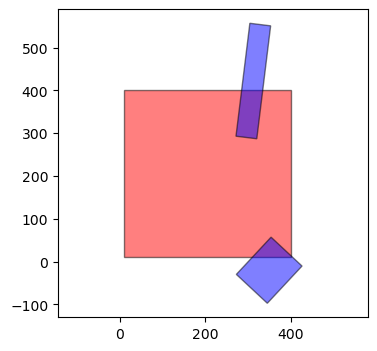

In [321]:
def get_centroid(sol: dict) -> Tuple[float, float]:
    """
    Get the centroid of a solution dict with ["x", "y", "long", "larg", "rot"] keys
    """
    return sol["x"] + sol["long"] / 2, sol["y"] + sol["larg"] / 2


def distance(sol1: dict, sol2: dict) -> float:
    """
    Compute the distance between two solutions
    """
    centroid1 = get_centroid(sol1)
    centroid2 = get_centroid(sol2)
    return np.sqrt((centroid1[0] - centroid2[0]) ** 2 + (centroid1[1] - centroid2[1]) ** 2)


def evaluate_cohesion(population: List[dict]) -> float:
    """
    Evaluate the cohesion of a population of solutions : the average distance between each solution and the centroid of the population
    """
    len_pop = len(population)
    total_distance = 0
    for i in range(len_pop):
        for j in range(i + 1, len_pop):
            total_distance += distance(population[i], population[j])

    return total_distance / (len_pop * (len_pop - 1) / 2)


test_pop = init_population(2, INF_DICT, SUP_DICT)

print("Cohesion : ", evaluate_cohesion(test_pop))
plot_rect_solutions(test_pop, PARCELLE_COORDS)

## ABC Algorithm

>>> Start ABC algorithm
>>> Parameters :
 * parcelle_coords : [(10, 10), (10, 400), (400, 400), (400, 10)]
 * population size : 30
 * type_neighbor : rand
 * max_trials_explorer_bee : 100
 * max_iter : 1000
 * max_iter_no_improvement : 50


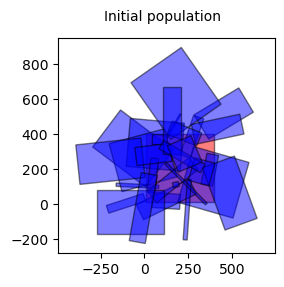

  1%|          | 10/1000 [00:06<04:31,  3.64it/s]

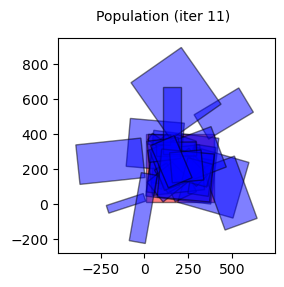

  5%|▌         | 50/1000 [00:17<03:06,  5.09it/s]

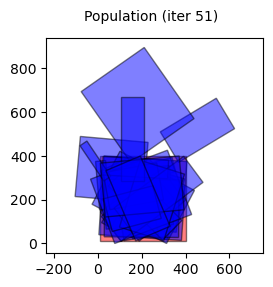

 10%|█         | 100/1000 [00:28<04:51,  3.09it/s]

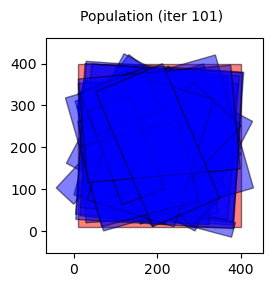

 15%|█▌        | 150/1000 [00:41<01:41,  8.40it/s]

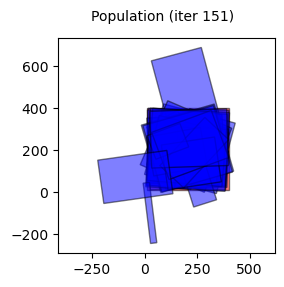

 20%|██        | 200/1000 [00:47<01:50,  7.26it/s]

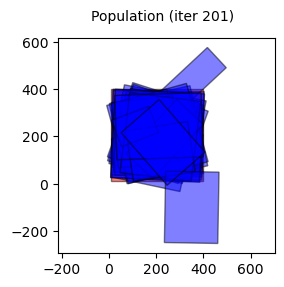

 30%|███       | 300/1000 [00:57<01:07, 10.41it/s]

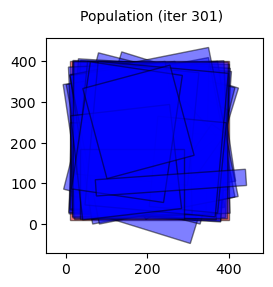

 40%|████      | 400/1000 [01:08<01:14,  8.01it/s]

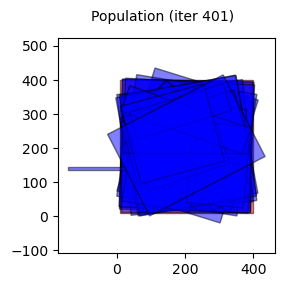

 40%|████      | 401/1000 [01:10<01:44,  5.73it/s]

>>> Break : no improvement since 50 iterations


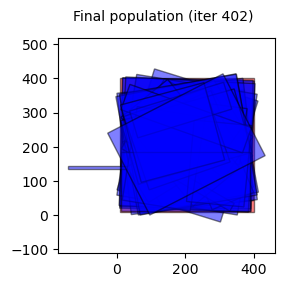

>>> Results after 401 iterations :
> Best solution at the end :
* {'x': 37.934466919575016, 'y': 335.84500010164953, 'long': 324.92077127500767, 'larg': 334.39096716928805, 'rot': 275.1221894114045}


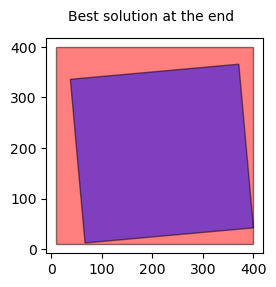

> Best solution since the beginning :
* {'x': 19.262661321771287, 'y': 400, 'long': 385.79521334612525, 'larg': 380.10129115623505, 'rot': 269.70793135149825}


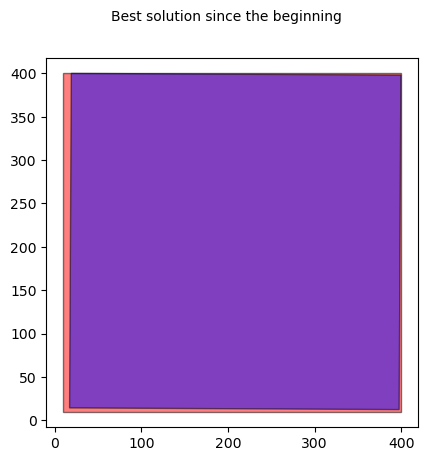

>>> Display history :


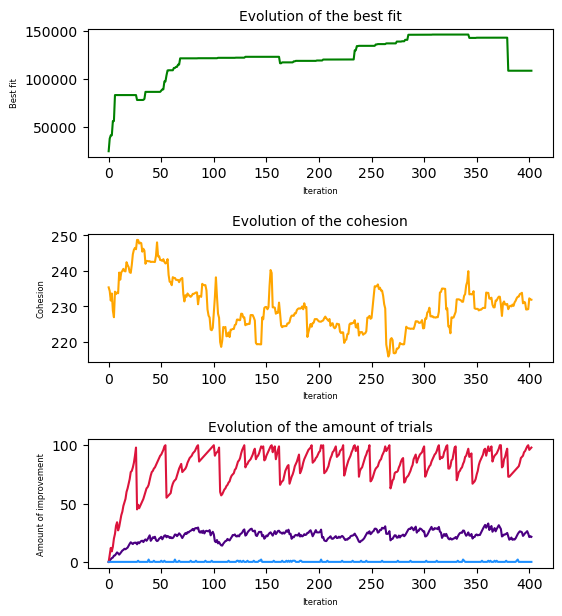

In [501]:

def plot_history(h_best_solution_fit, h_cohesion, h_amount_trials_mean, h_amount_trials_max, h_amount_trials_min,
                 title=""):
    # Plot the evolution of the best fit and cohesion (subplots)

    grid = plt.GridSpec(3, 1, hspace=0.6)
    fig = plt.figure(figsize=(6, 7))
    fig.suptitle(title)

    ax1 = fig.add_subplot(grid[0, :])
    ax1.plot(h_best_solution_fit, color='green')
    ax1.set_title('Evolution of the best fit', fontsize=10)
    ax1.set_xlabel('Iteration', fontsize=6)
    ax1.set_ylabel('Best fit', fontsize=6)

    ax2 = fig.add_subplot(grid[1, :])
    ax2.plot(h_cohesion, color='orange')
    ax2.set_title('Evolution of the cohesion', fontsize=10)
    ax2.set_xlabel('Iteration', fontsize=6)
    ax2.set_ylabel('Cohesion', fontsize=6)

    ax3 = fig.add_subplot(grid[2, :])
    ax3.plot(h_amount_trials_mean, color='indigo', label='Mean of trials')
    ax3.plot(h_amount_trials_max, color='crimson', label='Max of trials')
    ax3.plot(h_amount_trials_min, color='dodgerblue', label='Min of trials')
    ax3.set_title('Evolution of the amount of trials', fontsize=10)
    ax3.set_xlabel('Iteration', fontsize=6)
    ax3.set_ylabel('Amount of improvement', fontsize=6)
    #ax3.grid(color='gray', linestyle='--', linewidth=0.5)

    plt.show()


def ABC_algorithm_parcelle(parcelle_coords: List[tuple], pop_size: int, infs: dict = INF_DICT, sups: dict = SUP_DICT,
                           max_iter: int = 1000,
                           max_trials_explorer_bee: int = 100, type_neighbor: str = "rand",
                           max_iter_no_improvement_best_sol: int = 15, display_iter_population_plots=True,
                           iter_population_plots: list = [], display_history=True,
                           verbose: bool = True):
    #max_trials_explorer_bee = int(pop_size * max_iter * p_max_trials_explorer_bee )
    if verbose:
        print(">>> Start ABC algorithm")
        print(">>> Parameters :")
        print(f" * parcelle_coords : {parcelle_coords}")
        print(f" * population size : {pop_size}")

        #print(f" * p_max_trials_explorer_bee : {p_max_trials_explorer_bee}")
        print(f" * type_neighbor : {type_neighbor}")
        print(f" * max_trials_explorer_bee : {max_trials_explorer_bee}")
        print(f" * max_iter : {max_iter}")
        print(f" * max_iter_no_improvement : {max_iter_no_improvement_best_sol}")

    COEF_FIGSIZE = 0.7

    # initialization of the population
    sources_population = init_population(pop_size, infs, sups)
    trial_counter = np.zeros(pop_size)
    plot_rect_solutions(sources_population, parcelle_coords,
                        title="Initial population",
                        coef_figsize=COEF_FIGSIZE) if display_iter_population_plots else None
    # init history
    history_sources_population = [sources_population[:]]
    history_best_solution = [get_best_solution(sources_population, parcelle_coords)]
    history_cohesion = [evaluate_cohesion(sources_population)]
    history_amount_trials_mean = [trial_counter.mean()]
    history_amount_trials_max = [trial_counter.max()]
    history_amount_trials_min = [trial_counter.min()]

    if verbose:
        range_iter = tqdm(range(max_iter))
    else:
        range_iter = range(max_iter)

    iter_no_improvement = 0

    for num_iter in range_iter:
        # * Employed bees flight *

        # todo : add best_solution to the employed bees phase params, accelerate the algorithm
        sources_population, trial_counter = employed_bees_phase(sources_population, parcelle_coords=parcelle_coords,
                                                                trial_counter=trial_counter, infs=infs, sups=sups,
                                                                type_neighbor=type_neighbor, C=1.5)
        # * Onlooker bees flight *
        sources_population, trial_counter = onlooker_bees_phase(n_bees=pop_size, current_population=sources_population,
                                                                parcelle_coords=parcelle_coords, infs=infs, sups=sups,
                                                                trial_counter=trial_counter,
                                                                type_neighbor=type_neighbor, C=1)

        # * Explorer bees phase *
        sources_population, trial_counter = scout_bees_phase(current_population=sources_population,
                                                             trial_counter=trial_counter,
                                                             limit_trials=max_trials_explorer_bee,
                                                             parcelle_coords=parcelle_coords, infs=infs, sups=sups)

        # get the best solution
        best_solution = get_best_solution(sources_population, parcelle_coords=parcelle_coords)

        # historization
        history_sources_population.append(sources_population[:])
        history_best_solution.append(best_solution)
        history_amount_trials_mean.append(trial_counter.mean())
        history_amount_trials_max.append(trial_counter.max())
        history_amount_trials_min.append(trial_counter.min())
        history_cohesion.append(evaluate_cohesion(sources_population))

        # plot the population
        if num_iter in iter_population_plots and display_iter_population_plots:
            plot_rect_solutions(sources_population, parcelle_coords, title=f"Population (iter {num_iter + 1})",
                                coef_figsize=COEF_FIGSIZE)

        # check if no improvement since a while
        #best_since_beginning = get_best_solution(history_best_solution, parcelle_coords=parcelle_coords)
        if not is_better(history_best_solution[-1], history_best_solution[-2], parcelle_coords=parcelle_coords):
            iter_no_improvement += 1
            #print(f">>> No improvement since {iter_no_improvement} iterations")
            if iter_no_improvement >= max_iter_no_improvement_best_sol:
                if verbose:
                    print(f">>> Break : no improvement since {max_iter_no_improvement_best_sol} iterations")
                break
        else:
            iter_no_improvement = 0

    # final plot
    plot_rect_solutions(sources_population, parcelle_coords, title=f"Final population (iter {num_iter + 1})",
                        coef_figsize=COEF_FIGSIZE) if display_iter_population_plots else None

    # get the best solution since the beginning and at the end
    best_since_beginning = get_best_solution(history_best_solution, parcelle_coords=parcelle_coords)
    best_at_end = get_best_solution(sources_population, parcelle_coords=parcelle_coords)
    # display result
    if verbose:
        print(">>> Results after", num_iter, "iterations :")

        print("> Best solution at the end :")
        print(f"* {best_at_end}")
        plot_rect_solutions(solutions=[best_at_end], parcelle_coords=parcelle_coords, title="Best solution at the end",
                            coef_figsize=COEF_FIGSIZE)
        print("> Best solution since the beginning :")
        print(f"* {best_since_beginning}")
        plot_rect_solutions(solutions=[best_since_beginning], parcelle_coords=parcelle_coords,
                            title="Best solution since the beginning", coef_figsize=1.2)

    # display history
    if display_history:
        print(">>> Display history :")
        plot_history([fitness(x, parcelle_coords=parcelle_coords) for x in history_best_solution], history_cohesion,
                     history_amount_trials_mean,
                     history_amount_trials_max, history_amount_trials_min)

    return {
        "best_since_beginning": best_since_beginning,
        "best_at_end": best_at_end,
        "history_best_solution": history_best_solution,
        "history_cohesion": history_cohesion,
        "history_sources_population": history_sources_population,
        "history_amount_trials_mean": history_amount_trials_mean,
        "history_amount_trials_max": history_amount_trials_max}


_ = ABC_algorithm_parcelle(parcelle_coords=PARCELLE_COORDS, pop_size=30, max_trials_explorer_bee=100,
                           type_neighbor="rand", max_iter=1000, max_iter_no_improvement_best_sol=50,
                           display_iter_population_plots=True,
                           iter_population_plots=[10, 50, 100, 150, 200, 300,400, 500, 600, 700, 800],
                           display_history=True, verbose=True)